# **1. Introdução**

Este projeto foi desenvolvido como parte do curso Profissão Analista de Dados da Escola Britânica de Artes Criativas e Tecnologia (EBAC). O objetivo do projeto era construir um pipeline de dados em nuvem para ingerir, processar e armazenar mensagens de texto disparadas em um grupo no aplicativo de mensagens Telegram. Foi adicionado ao grupo um bot, criado dentro da própria plataforma, responsável por captar as mensagens e encaminha-lás via API para a plataforma cloud Amazon Web Services (AWS).

**Chatbot**

Um chatbot é um tipo de software que interage com usuários através de conversas automatizadas em plataformas de mensagens. Uma aplicação comum de chatbots é o seu uso no atendimento ao cliente, onde, de maneira geral, ajudam clientes a resolver problemas ou esclarecer dúvidas recorrentes antes mesmo que um atendente humano seja acionado.

**Telegram**

Telegram é uma plataforma de mensagens instantâneas freeware (distribuído gratuitamente) e, em sua maioria, open source. É muito popular entre desenvolvedores por ser pioneiro na implantação da funcionalidade de criação de chatbots, que, por sua vez, permitem a criação de diversas automações.

**Arquitetura**

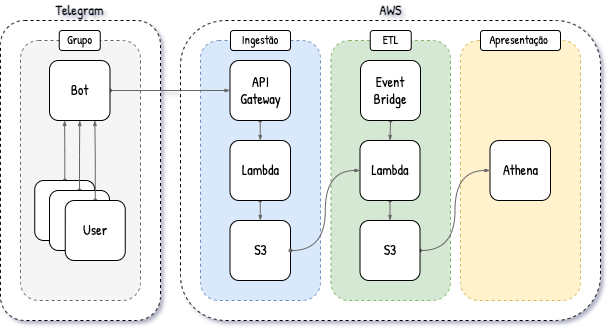!




**Importação**

In [1]:
from getpass import getpass
import json
import os
import pandas as pd
import logging
from datetime import datetime, timedelta, timezone
import boto3
import pyarrow as pa
import pyarrow.parquet as pq
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# **2. Telegram**

**2.1. Conta**

Para criar uma conta no Telegram, basta fazer o download do aplicativo na loja de aplicativos do seu smartphone. Uma vez criada, acesse sua conta através da versão web da plataforma de mensagens neste link.

**2.2. Bot**

Para criar um bot:

Abra o chat com o BotFather;
Digite /newbot;
Digite o nome do bot;
Digite o nome de usuário do bot (precisa terminar com sufixo _bot);
Salve o token de acesso a API HTTP em um local seguro.
Para conferir o token novamente:

Abra o chat com o BotFather;
Digite /mybots;
Selecione o bot pelo seu nome de usuário;
Selecione API Token.
Por fim, precisamos ativiar o bot.

Abra o chat com o bot;
Selecione start.

**2.3. Grupo**

Para criar um novo grupo.

Aperte o botão com o ícone de um lápis;
Selecione New Group;
Busque e selecione o bot recém criado pelo seu nome;
Aperte o botão com o ícone de uma seta;
Digite o nome do grupo.
Com o grupo criado, vamos adicionar o bot como administrador para que ele possa receber todas as mensagens do grupo. Uma outra opção seria desabilitar o seu modo de privacidade.

Abra o chat do grupo recém criado;
Abra o perfil do grupo;
Aperte o botão com o ícone de um lápis;
No campo de descrição do grupo escreva: Atenção, todas as mensagens são armazenadas pelo bot do grupo;
Selecione Administrators;
Aperte o botão com o ícone de um usuário;
Selecione o bot.
Aperte o botão com o ícone de um check.
Por fim, vamos configurar o bot para que ele não possa ser adicionado a outros grupos.

Abra o chat com o BotFather;
Digite /mybots;
Selecione o bot pelo seu nome de usuário;
Selecione Bot Settings;
Selecione Allow Groups?;
Selecione Turn groups off.
Com tudo pronto, envie algumas mensagens no grupo.

**2.4. Bot API**

As mensagens captadas por um bot podem ser acessadas via API. A única informação necessária é o token de acesso fornecido pelo BotFather na criação do bot.

In [2]:
token = getpass()

StdinNotImplementedError: getpass was called, but this frontend does not support input requests.

In [ ]:
base_url = f'https://api.telegram.org/bot{token}'

# **3. Dados**

Uma mensagem recuperada via API é um dado semi-estruturado no formato JSON com algumas chaves mandatórias e diversas chaves opcionais, estas últimas presentes (ou não) dependendo do tipo da mensagem. Por exemplo, mensagens de texto apresentam a chave text enquanto mensagens de áudio apresentam a chave audio. Neste projeto vamos focar em mensagens do tipo texto, ou seja, vamos ingerir as chaves mandatórias e a chave text.

O código abaixo recebe as mensagens do Telegram via API Gateway, verifica no seu conteúdo e as escreve em seu formato original JSON, em um bucket criado no AWS S3 nomeado "modulo-final-datalake-raw".

In [ ]:
def lambda_handler(event: dict, context: dict) -> dict:

  #variáveis de ambiente

  BUCKET = os.environ['AWS_S3_BUCKET']
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])

  #variáveis lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  filename = f'{timestamp}.json'

  #código 

  client = boto3.client('s3')
  
  try:

    message = json.loads(event["body"])
    chat_id = message["message"]["chat"]["id"]

    if chat_id == TELEGRAM_CHAT_ID:

      with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
        json.dump(message, fp)

      client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')

  except Exception as exc:
      logging.error(msg=exc)
      return dict(statusCode="500")

  else:
      return dict(statusCode="200")

In [ ]:
#método setWebhook configura o redirecionamento das mensagens captadas pelo bot para o endereço web do parâmetro url.
response = requests.get(url=f'{base_url}/setWebhook?url={aws_api_gateway_url}')

print(json.dumps(json.loads(response.text), indent=2))

In [ ]:
 #método getWebhookInfo retorna as informações sobre o webhook configurado.
response = requests.get(url=f'{base_url}/getWebhookInfo')

print(json.dumps(json.loads(response.text), indent=2))

# **4. ETL**

As mensagens de um único dia, persistidas na camada cru, serão compactas em um único arquivo, orientado a coluna e comprimido, que será persistido em uma camada enriquecida. Além disso, durante este processo, o dado também passará por etapas de data wrangling. Vamos utilizar uma função do AWS Lambda como motor de processamento e um bucket do AWS S3 como camada enriquecida para a persistência do dado processado. Para garantir a recorrência, vamos configurar uma regra do AWS Event Bridge como gatilho diáro da função.

O código abaixo é executado diariamente pelo AWS Event Brigde - em horário pré-estabelecido:

In [ ]:
#O código da função:

def lambda_handler(event: dict, context: dict) -> bool:

  '''
  Diariamente é executado para compactar as diversas mensagensm, no formato
  JSON, do dia anterior, armazenadas no bucket de dados cru, em um único 
  arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos
  '''

  # vars de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # código principal

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None
          
      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True
  
  except Exception as exc:
      logging.error(msg=exc)
      return False

In [ ]:
#O código da função de data wrangling:

def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data

Para que a função funcione corretamente, algumas configurações precisam ser realizadas.

**Variáveis de ambiente**
Note que o código exige a configuração de duas variáveis de ambiente: AWS_S3_BUCKET e AWS_S3_ENRICHED com os nomes dos bucket do AWS S3 da camada cru e enriquecida, respectivamente. Para adicionar variáveis de ambiente em uma função do AWS Lambda, basta acessar configurações -> variáveis de ambiente no console da função.

**Permissão**
Precisamos adicionar a permissão de escrita nos buckets do AWS S3 para a função do AWS Lambda no AWS IAM.

**Recursos**
O timeout padrão de funcões do AWS Lambda é de 3 segundos. Para a função, vamos aumentar o tempo para 5 minutos, principalmente para lidar com o IO (input/output) de arquivos do AWS S3.

**Camadas**
O código da função utiliza o pacote Python PyArrow. Contudo, o ambiente padrão do AWS Lambda possui poucos pacotes externos instalado, como o pacote Python boto3, logo o PyArrow não será encontrado e a execução da função falhará. Existem algumas formas de adicionar pacotes externos no ambiente de execução do AWS Lambda, um deles é a criação de camadas ou layers, onde podemos fazer o upload dos pacotes Python direto na plataforma.

**AWS Event Bridge**
Na etapa de ETL, o AWS Event Bridge tem a função de ativar diariamente a função de ETL do AWS Lambda, funcionando assim como um scheduler.

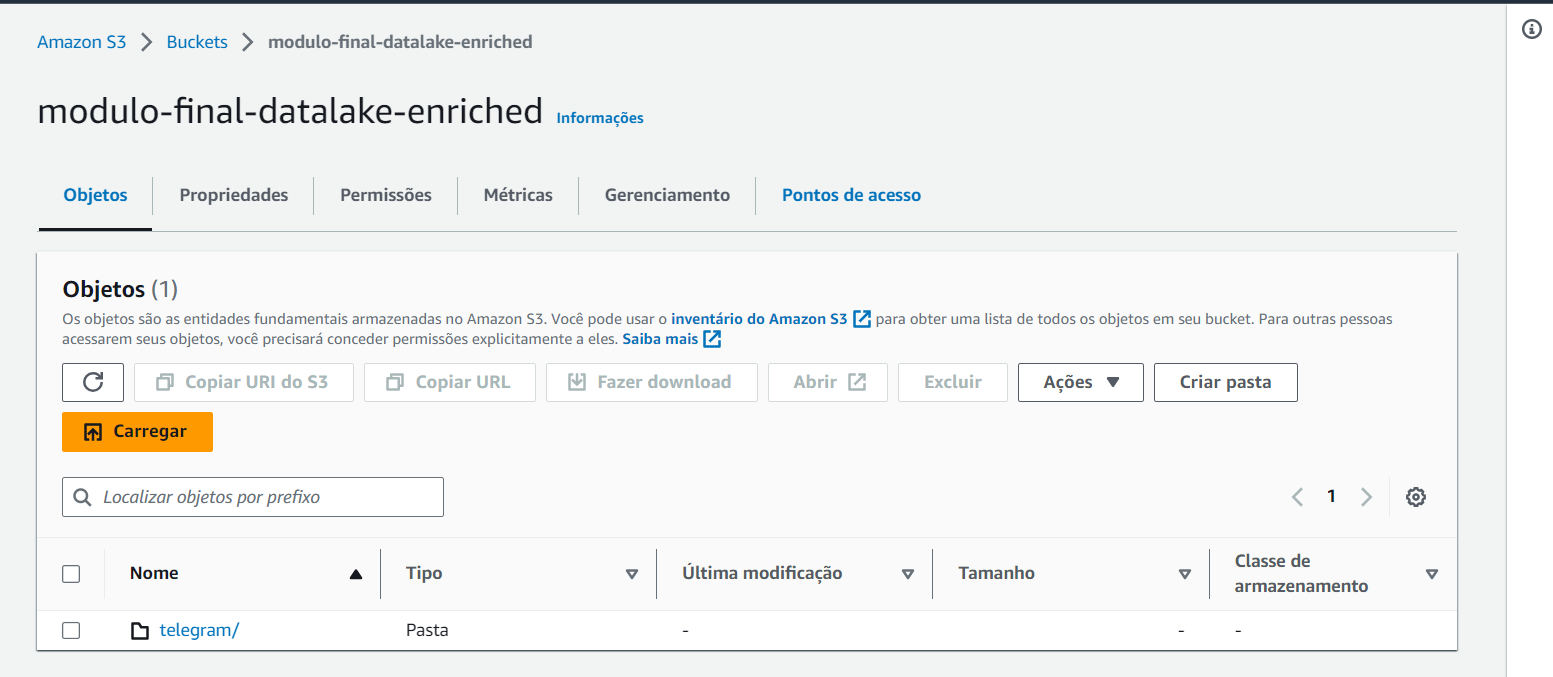


# **5. Análise de dados**
Criação da tabela no AWS Athena.

Tabela criada com a seguinte query:

In [ ]:
CREATE EXTERNAL TABLE `telegram`(
  `message_id` bigint, 
  `user_id` bigint, 
  `user_is_bot` boolean, 
  `user_first_name` string, 
  `chat_id` bigint, 
  `text` string) 
PARTITIONED BY ( 
  `context_date` date)
ROW FORMAT SERDE 
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe' 
STORED AS INPUTFORMAT 
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat' 
OUTPUTFORMAT 
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION
  's3://modulo-final-datalake-enriched/telegram/'

In [ ]:
#adicionar as partições disponíveis
MSCK REPAIR TABLE `telegram`;

In [ ]:
SELECT * FROM `telegram` LIMIT 10;

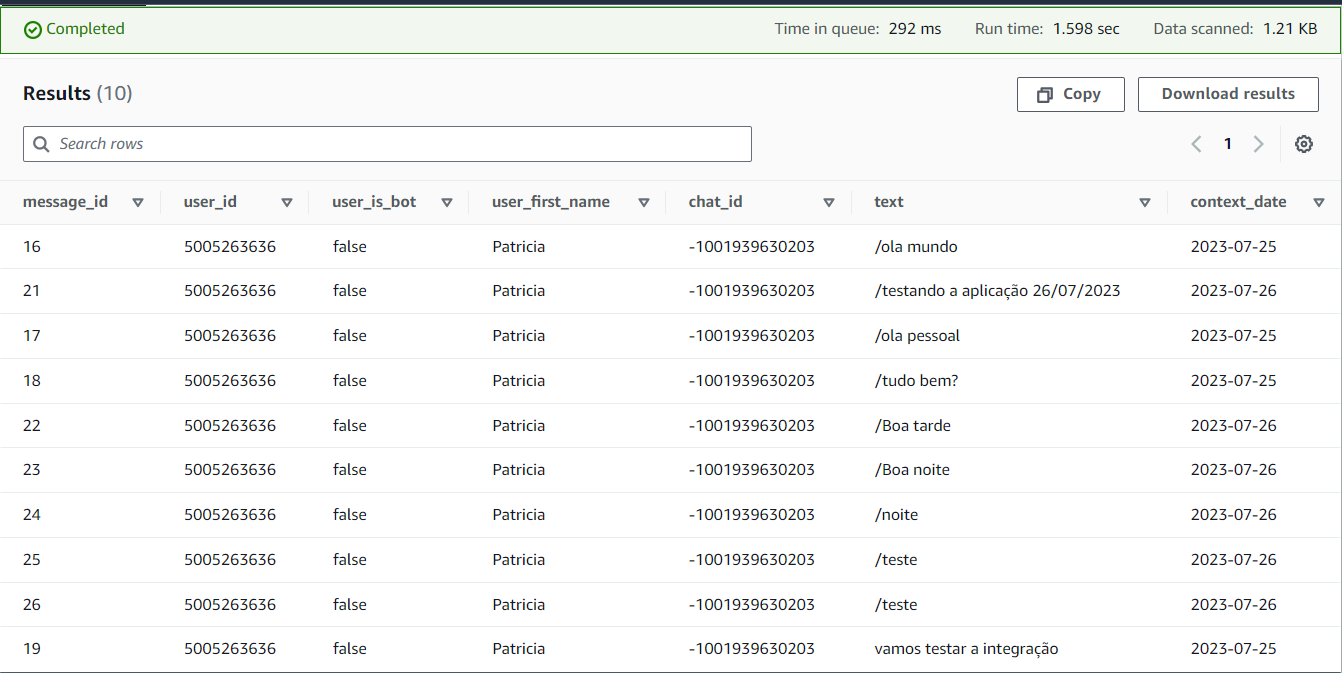

In [ ]:
#Quantidade de mensagens por dia.
SELECT 
  context_date, 
  count(1) AS "message_amount" 
FROM "telegram" 
GROUP BY context_date 
ORDER BY context_date DESC

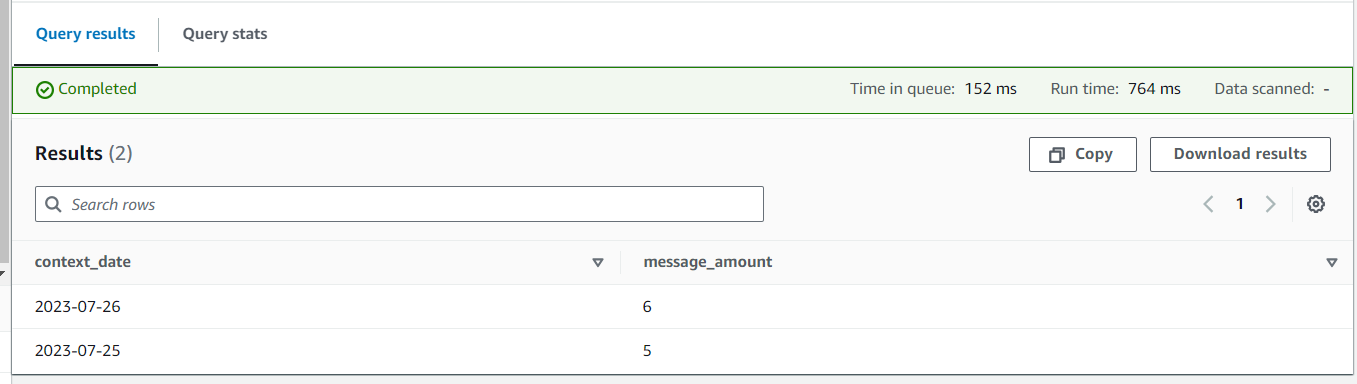

In [ ]:
#Quantidade de mensagens por usuário por dia.
SELECT 
  user_id, 
  user_first_name, 
  context_date, 
  count(1) AS "message_amount" 
FROM "telegram" 
GROUP BY 
  user_id, 
  user_first_name, 
  context_date 
ORDER BY context_date DESC

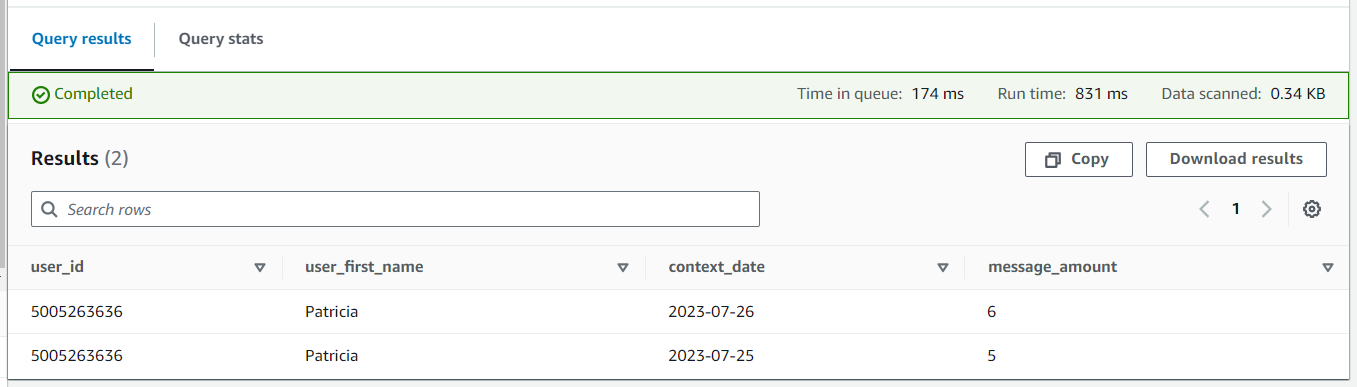

In [ ]:
#Média do tamanho das mensagens por usuário por dia.
SELECT 
  user_id, 
  user_first_name, 
  context_date,
  CAST(AVG(length(text)) AS INT) AS "average_message_length" 
FROM "telegram" 
GROUP BY 
  user_id, 
  user_first_name, 
  context_date 
ORDER BY context_date DESC

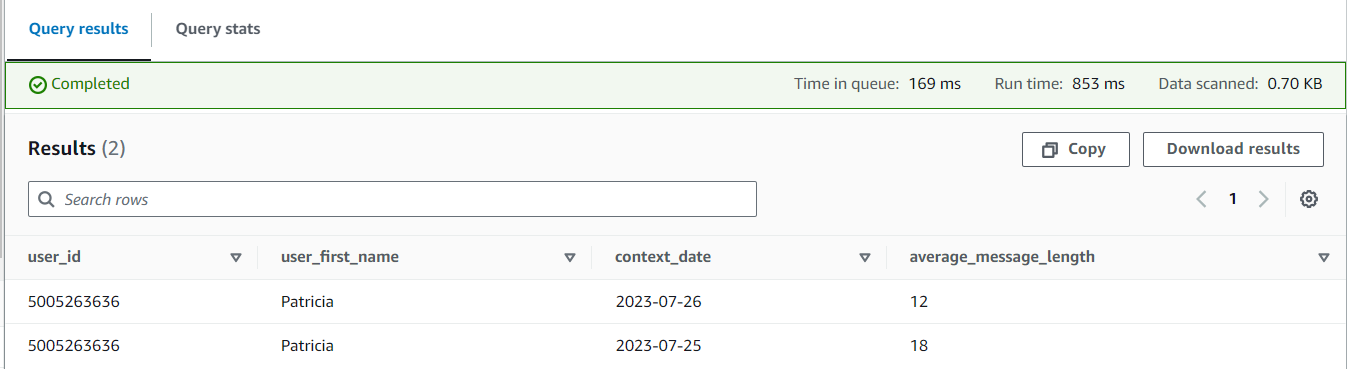

In [ ]:
#Quantidade de mensagens por hora por dia da semana por número da semana.
WITH 
parsed_date_cte AS (
    SELECT 
        *, 
        CAST(date_format(from_unixtime("date"),'%Y-%m-%d %H:%i:%s') AS timestamp) AS parsed_date
    FROM "telegram" 
),
hour_week_cte AS (
    SELECT
        *,
        EXTRACT(hour FROM parsed_date) AS parsed_date_hour,
        EXTRACT(dow FROM parsed_date) AS parsed_date_weekday,
        EXTRACT(week FROM parsed_date) AS parsed_date_weeknum
    FROM parsed_date_cte
)
SELECT
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum,
    count(1) AS "message_amount" 
FROM hour_week_cte
GROUP BY
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum
ORDER BY
    parsed_date_weeknum,
    parsed_date_weekday

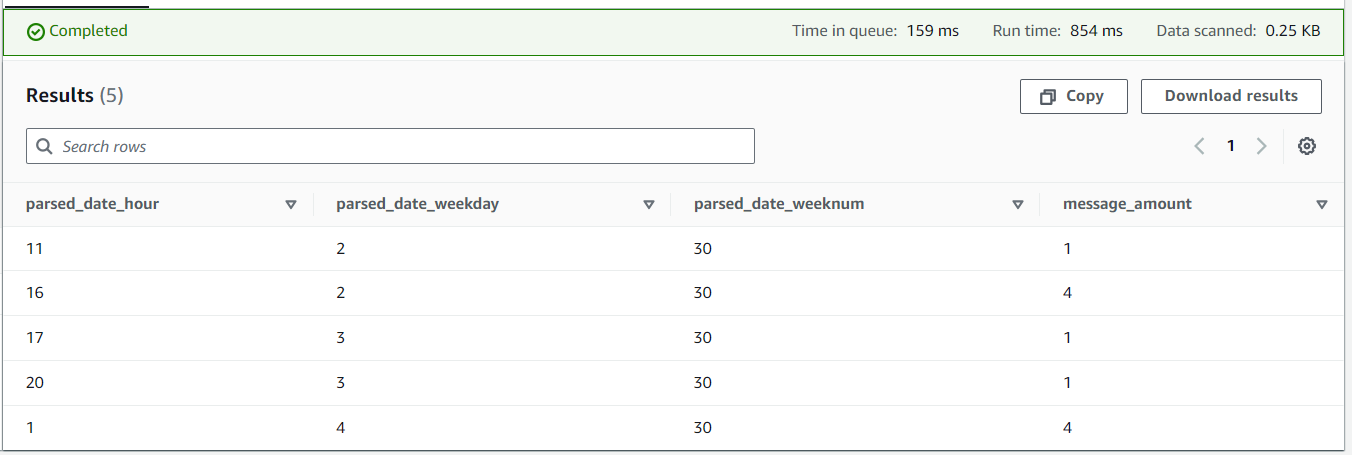

In [ ]:
mensagens = pd.read_csv('/kaggle/input/telegram/telegram.csv')

In [ ]:
mensagens.head()

In [ ]:
grafico= sns.countplot(data= mensagens, x='context_date',palette= 'pastel');
grafico.set(title='Distribuição por de mensagens por data',xlabel='data', ylabel='Número de mensagens')